<a href="https://colab.research.google.com/github/ZakByeol/TradeChart/blob/main/TradeChart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install finance-datareader #finance-datareader 모듈 설치 / 해당 모듈은 한국 시장도 잘 지원되어있음

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.0/89.0 kB 870.1 kB/s eta 0:00:00


In [2]:
pip install mplfinance #mplfinance 모듈 설치 / 금융 데이터(주식 시장)을 시각화하기 위한 라이브러이

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 810.7 kB/s eta 0:00:00


In [3]:
pip install ta # RSI 지표활용

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29411 sha256=c534ffd4d99a010287fc355714011a0408b116dcded301b46be3ad647cdcb52c
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


주식 코드를 입력하세요 (예: 국내주식은 상장코드로, 해외주식은 주식코드로 입력): BSX
기간을 선택하세요:
1. 1주 (1W)
2. 1달 (1M)
3. 6달 (6M)
4. 1년 (1Y)
선택 (1-4): 3
추세를 선택하세요:
1. 단기 추세
2. 장기 추세
선택 (1-2): 2


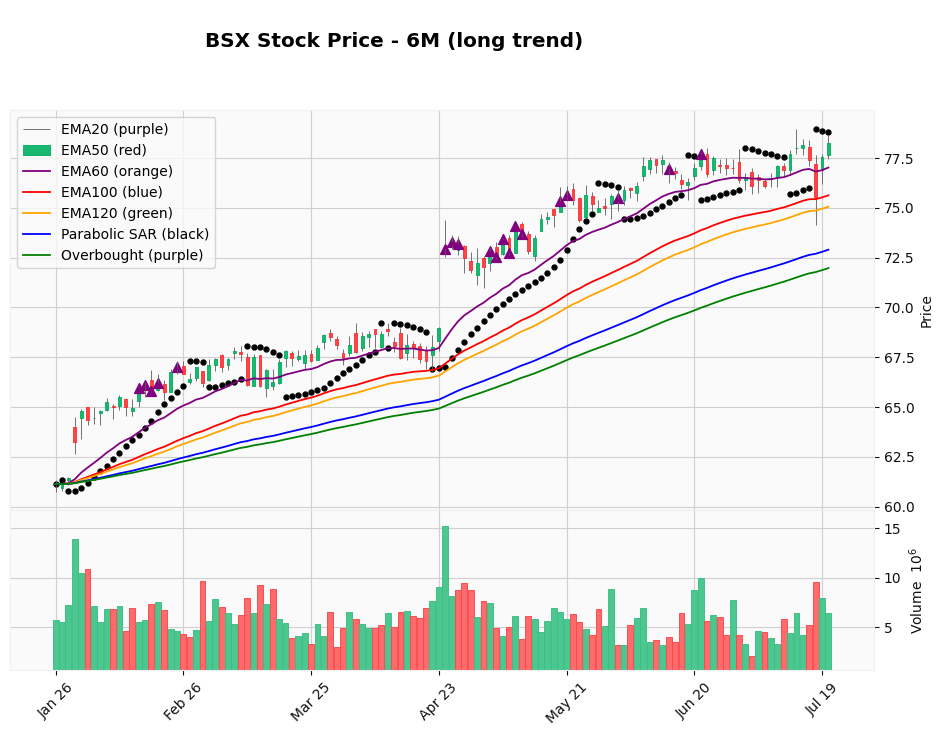

In [7]:
import FinanceDataReader as fdr  # 금융 데이터를 가져오기 위한 라이브러리
import mplfinance as mpf  # 금융 차트를 그리기 위한 라이브러리
import pandas as pd  # 데이터 조작 및 분석을 위한 라이브러리
import numpy as np  # 수치 연산을 위한 라이브러리
from datetime import datetime, timedelta  # 날짜 및 시간 조작을 위한 모듈
import matplotlib.pyplot as plt  # 차트를 그리기 위한 모듈

# 기간 차트 선택
# FinaceDataReader를 사용해, 해당 기간의 주식 데이터를 return 함
def get_stock_data(ticker, period):
    end_date = datetime.now()  # 현재 날짜를 종료 날짜로 설정
    if period == '1W':
        start_date = end_date - timedelta(weeks=1)  # 1주일 전 날짜 계산
    elif period == '1M':
        start_date = end_date - timedelta(days=30)  # 1달 전 날짜 계산
    elif period == '6M':
        start_date = end_date - timedelta(days=180)  # 6달 전 날짜 계산
    elif period == '1Y':
        start_date = end_date - timedelta(days=365)  # 1년 전 날짜 계산
    else:
        raise ValueError("Invalid period")  # 잘못된 기간 입력 시 에러 발생

    data = fdr.DataReader(ticker, start_date, end_date)  # FinanceDataReader를 사용하여 주식 데이터 가져오기
    return data  # 가져온 데이터 반환

# 단기적 추세의 경우, EMA5 EMA10을 활용해 계산
# 장기적 추세의 경우, EMA20 EMA50 EMA60 EMA100 EMA120
# Parabolic SAR을 활용해 계산
def add_indicators(data, trend):
    if trend == 'short':
        data['EMA5'] = data['Close'].ewm(span=5, adjust=False).mean()  # 5일 지수이동평균 계산
        data['EMA10'] = data['Close'].ewm(span=10, adjust=False).mean()  # 10일 지수이동편균 계산
    else:
        data['EMA20'] = data['Close'].ewm(span=20, adjust=False).mean()  # 20일 지수이동평균 계산
        data['EMA50'] = data['Close'].ewm(span=50, adjust=False).mean()  # 50일 지수이동평균 계산
        data['EMA60'] = data['Close'].ewm(span=60, adjust=False).mean()  # 60일 지수이동편균 계산
        data['EMA100'] = data['Close'].ewm(span=100, adjust=False).mean()  # 100일 지수이동평균 계산
        data['EMA120'] = data['Close'].ewm(span=120, adjust=False).mean()  # 120일 지수이동평균 계산

        # Parabolic SAR 계산
        data['SAR'] = data['Close'].copy()  # SAR 초기값 설정
        af = 0.02  # 가속변수 초기값
        max_af = 0.2  # 최대 가속변수
        ep = data['High'].iloc[0]  # 초기 극점 설정
        # 극점(신고가,신저가)에 도달하면 af만큼 증가하고, 최대 0.2여야함
        trend = 1  # 초기 추세 (상승으로 잡아둠)
        for i in range(1, len(data)):

            # SAR = SAR(전날) + {AF(EP-SAR(*))}
            if trend == 1:
                data.loc[data.index[i], 'SAR'] = data.loc[data.index[i-1], 'SAR'] + af * (ep - data.loc[data.index[i-1], 'SAR'])  # 상승 추세일 때 SAR 계산
            else:
                data.loc[data.index[i], 'SAR'] = data.loc[data.index[i-1], 'SAR'] - af * (data.loc[data.index[i-1], 'SAR'] - ep)  # 하락 추세일 때 SAR 계산

            # 상향 추세 : (2일 차 고가 - 1일 차 고가) > (1일 차 저가 - 2일 차 저가)
            # 하향 추세 : (2일 차 고가 - 1일 차 고가) < (1일 차 저가 - 2일 차 저가)
            if trend == 1:
                if data.loc[data.index[i], 'Low'] < data.loc[data.index[i], 'SAR']:  # 상승에서 하락으로 전환
                    trend = -1
                    data.loc[data.index[i], 'SAR'] = ep
                    ep = data.loc[data.index[i], 'Low']
                    af = 0.02
                else:
                    if data.loc[data.index[i], 'High'] > ep:  # 새로운 고점 갱신
                        ep = data.loc[data.index[i], 'High']
                        af = min(af + 0.02, max_af)
            else:
                if data.loc[data.index[i], 'High'] > data.loc[data.index[i], 'SAR']:  # 하락에서 상승으로 전환
                    trend = 1
                    data.loc[data.index[i], 'SAR'] = ep
                    ep = data.loc[data.index[i], 'High']
                    af = 0.02
                else:
                    if data.loc[data.index[i], 'Low'] < ep:  # 새로운 저점 갱신
                        ep = data.loc[data.index[i], 'Low']
                        af = min(af + 0.02, max_af)

    # RSI 계산
    delta = data['Close'].diff()  # 종가의 변화량 계산
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()  # 14일 평균 상승폭
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()  # 14일 평균 하락폭
    rs = gain / loss  # 상대강도(RS) 계산
    data['RSI'] = 100 - (100 / (1 + rs))  # RSI 계산

    return data  # 지표가 추가된 데이터 반환

def plot_stock_chart(ticker, period, trend):
    data = get_stock_data(ticker, period)  # 주식 데이터 가져오기
    data = add_indicators(data, trend)  # 기술적 지표 추가

    # 데이터 컬럼명 변경
    data = data.rename(columns={
        'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Volume': 'volume'
    })
    # mplfinance 라이브러리 요구사항에 맞게 컬럼명 변경
    # 요구사항!!!!!

    # 추가 플롯 설정
    apds = []  # 추가 플롯을 저장할 리스트
    legend = []  # 라벨?을 저장할 리스트

    if trend == 'short':
        apds.extend([
            mpf.make_addplot(data['EMA5'], color='red'),  # 5일 EMA 추가
            mpf.make_addplot(data['EMA10'], color='blue')  # 10일 EMA 추가
        ])
        legend.extend(['EMA5 (red)', 'EMA10 (blue)'])  # 범례 추가
    else:
        apds.extend([
            mpf.make_addplot(data['EMA20'], color='purple'),  # 20일 EMA 추가
            mpf.make_addplot(data['EMA50'], color='red'),  # 50일 EMA 추가
            mpf.make_addplot(data['EMA60'], color='orange'),  # 60일 EMA 추가
            mpf.make_addplot(data['EMA100'], color='blue'),  # 100일 EMA 추가
            mpf.make_addplot(data['EMA120'], color='green'),  # 120일 EMA 추가
            mpf.make_addplot(data['SAR'], type='scatter', markersize=50, marker='.', color='black')  # Parabolic SAR 추가
        ])
        legend.extend(['EMA20 (purple)', 'EMA50 (red)', 'EMA60 (orange)', 'EMA100 (blue)', 'EMA120 (green)', 'Parabolic SAR (black)'])  # 범례 추가

    # RSI 과매도/과매수 구간 표시
    # Handle potential empty arrays for overbought and oversold
    overbought = data['close'].where(data['RSI'] > 70, np.nan)  # RSI 70 이상인 지점 (과매수)
    oversold = data['close'].where(data['RSI'] < 30, np.nan)  # RSI 30 이하인 지점 (과매도)
    if not np.isnan(overbought).all():  # Check if overbought array is not all NaN
        apds.append(mpf.make_addplot(overbought, type='scatter', markersize=50, marker='^', color='purple'))  # 과매수 지점 표시
        legend.append('Overbought (purple)')
    if not np.isnan(oversold).all():  # Check if oversold array is not all NaN
        apds.append(mpf.make_addplot(oversold, type='scatter', markersize=50, marker='v', color='lime'))  # 과매도 지점 표시
        legend.append('Oversold (lime)')

    # 차트 그리기
    fig, axes = mpf.plot(data, type='candle', style='yahoo',title=f"\n{ticker} Stock Price - {period} ({trend} trend)",volume=True, figsize=(12, 8),addplot=apds, returnfig=True)  # 캔들스틱 차트 생성

    # 범례 추가
    axes[0].legend(legend)  # 범례 표시

    plt.show()  # 차트 표시

# 메인 프로그램
ticker = input("주식 코드를 입력하세요 (예: 국내주식은 상장코드로, 해외주식은 주식코드로 입력): ")  # 사용자로부터 주식 코드 입력 받기
print("기간을 선택하세요:")
print("1. 1주 (1W)")
print("2. 1달 (1M)")
print("3. 6달 (6M)")
print("4. 1년 (1Y)")
period_choice = input("선택 (1-4): ")  # 사용자로부터 기간 선택 받기

period_map = {'1': '1W', '2': '1M', '3': '6M', '4': '1Y'}  # 사용자 입력을 기간 문자열로 매핑
period = period_map.get(period_choice)  # 선택된 기간 가져오기

print("추세를 선택하세요:")
print("1. 단기 추세")
print("2. 장기 추세")
trend_choice = input("선택 (1-2): ")  # 사용자로부터 추세 선택 받기

trend_map = {'1': 'short', '2': 'long'}  # 사용자 입력을 추세 문자열로 매핑
trend = trend_map.get(trend_choice)  # 선택된 추세 가져오기

if period and trend:
    plot_stock_chart(ticker, period, trend)  # 주식 차트 그리기
else:
    print("잘못된 선택입니다.")  # 잘못된 입력 처리